In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np


In [57]:

#Choosing which years/files to read
el_csv_files = ["Day-ahead Prices_202301010000-202401010000.csv"]
electricity_df = pd.DataFrame()
start_date = datetime(year = 2023, month = 1, day=1, hour=0, minute=0)
end_date = datetime(year=2023, month = 11, day = 3)

#Processing electricity prices

for filename in el_csv_files:
    process_df = pd.read_csv(filename)
    electricity_df = pd.concat([electricity_df,process_df])

electricity_df = electricity_df[electricity_df["Day-ahead Price [EUR/MWh]"] != "-"].drop(labels = "BZN|CH", axis = 1)
electricity_df[['time_start','time_stop']] = electricity_df['MTU (CET/CEST)'].str.split(' - ',expand=True)
electricity_df["time_start"] = pd.to_datetime(electricity_df["time_start"], format = "%d.%m.%Y %H:%M")
electricity_df["time_stop"] = pd.to_datetime(electricity_df["time_stop"], format = "%d.%m.%Y %H:%M")
electricity_df["Day-ahead Price [EUR/MWh]"] = pd.to_numeric(electricity_df["Day-ahead Price [EUR/MWh]"])
    

interval_size_int = 4
interval_size = pd.Timedelta(hours=interval_size_int)

electricity_df["average_electricity_price"] = pd.Series()
prices_series = pd.Series()
date_iterator = start_date
while date_iterator < end_date:
    df = electricity_df [(electricity_df["time_start"] >= date_iterator) & (electricity_df["time_start"]< date_iterator + interval_size)]
    #Finding the average 4 hour price in EUR/MW
    avg_price = df["Day-ahead Price [EUR/MWh]"].sum()
    indices = list(df.index.values)
    electricity_df.loc[indices[0]:indices[-1],"average_electricity_price"] = avg_price 
    date_iterator = date_iterator+interval_size
electricity_df = electricity_df[electricity_df["time_start"].dt.hour%4 ==0].drop(labels = ["MTU (CET/CEST)", "Day-ahead Price [EUR/MWh]","time_stop"], axis =1)
electricity_df

,Currency,time_start,average_electricity_price
0,EUR,2023-01-01 00:00:00,-18.92
4,EUR,2023-01-01 04:00:00,-39.85
8,EUR,2023-01-01 08:00:00,-7.04
12,EUR,2023-01-01 12:00:00,14.76
16,EUR,2023-01-01 16:00:00,119.95
...,...,...,...
7325,EUR,2023-11-02 04:00:00,180.58
7329,EUR,2023-11-02 08:00:00,260.94
7333,EUR,2023-11-02 12:00:00,254.87
7337,EUR,2023-11-02 16:00:00,364.75


In [85]:
#processing ancillary bids to find average bid, max bid, and min bid per 4-hour session

ancillary_df = pd.DataFrame()

an_csv_files = ["2023-PRL-SRL-TRL-Ergebnis.csv"]
ancillary_df = pd.DataFrame()
start_date = datetime(year = 2023, month = 1, day=1, hour=0, minute=0)
end_date = datetime(year=2023, month = 11, day = 3)

for filename in an_csv_files:
    process_df = pd.read_csv(filename, sep = ";", low_memory=False)
    ancillary_df = pd.concat([ancillary_df,process_df])
print(ancillary_df.columns)
#specifying and filtering by ancillary service type
ancillary_type = "PRL"
ancillary_df = ancillary_df[ancillary_df["Ausschreibung"].str[0:3] == ancillary_type]

#ancillary_df = ancillary_df.apply(lambda col: pd.to_numeric(col, downcast= 'float', errors = "ignore"), axis = 1)

day = ancillary_df["Ausschreibung"].str[-8:]
time = ancillary_df["Beschreibung"].str[-len("00:00 bis 04:00"):]
time_string = day + " " + time.str[0:5]
ancillary_df["time_start"] = pd.to_datetime(time_string, format = "%y_%m_%d %H:%M")



#We see by unhashing the line below that volume that cannot be parted is relatively small so we can look away from that in the first place
#print(ancillary_df[ancillary_df["Teilbarkeit"] != "Ja"]["Angebotenes Volumen"].sum()/ancillary_df["Angebotenes Volumen"].sum())

ancillary_df["average_ancillary_price"] = pd.Series()
ancillary_df["max_ancillary_price"] = pd.Series()
ancillary_df["min_ancillary_price"] = pd.Series()
for time in ancillary_df["time_start"].unique():
    df = ancillary_df[ancillary_df["time_start"] == time]
    avg_price = df["Kosten"].sum()/df["Zugesprochenes Volumen"].sum()
    indices = list(df.index.values)
    ancillary_df.loc[indices[0]:indices[-1],"average_ancillary_price"] = avg_price
    ancillary_df.loc[indices[0]:indices[-1],"max_ancillary_price"] = df["Leistungspreis"].max()
    ancillary_df.loc[indices[0]:indices[-1],"min_ancillary_price"] = df["Leistungspreis"].min()

#We are at the moment only keeping the 'Leisungspreis' out of the prices
ancillary_df.drop(columns=ancillary_df.columns[:4],axis=1, inplace=True)
ancillary_df.drop(columns=ancillary_df.columns[4:8], axis = 1, inplace=True)
ancillary_df.drop(columns = ancillary_df.columns[5:7],axis = 1,inplace = True)
#ancillary_df.drop(columns=ancillary_df.columns[])

#Unhash line below to get only bids in Switzerland
#ancillary_df = ancillary_df[ancillary_df["Land"] == "CH"]

#Renaming columns
unit_column_names = ancillary_df[ancillary_df.columns[1::2]].values[0]
new_column_names = ["volume_sold ["+ str(unit_column_names[0]) + "]","ancillary_price [" + str(unit_column_names[1])+"]", "country", "divisibility"]
ancillary_df.drop(columns=ancillary_df.columns[1:4:2], axis =1, inplace=True)
ancillary_df = ancillary_df.rename(columns=dict(zip(["Zugesprochenes Volumen","Leistungspreis","Land","Teilbarkeit"],new_column_names)))

#Defining a capacity for the powerplant to filter the dataframe
capacity = 10

for date in ancillary_df["time_start"].unique():
    date_df = ancillary_df[ancillary_df["time_start"] == date].sort_values(by = "ancillary_price [EUR/MW]",ascending = False)
    #adding electricity price
ancillary_df

Index(['Ausschreibung', 'Beschreibung', 'Angebotenes Volumen', 'Einheit',
       'Zugesprochenes Volumen', 'Einheit.1', 'Leistungspreis', 'Einheit.2',
       'Kosten', 'Einheit.3', 'Preis', 'Einheit.4', 'Land', 'Angebotspreis',
       'Einheit.5', 'Teilbarkeit'],
      dtype='object')


,volume_sold [MW],ancillary_price [EUR/MW],country,divisibility,time_start,average_ancillary_price,max_ancillary_price,min_ancillary_price
0,5,80.0,CH,Ja,2023-01-01 00:00:00,12.340364,139.28,0.0
1,1,54.4,CH,Ja,2023-01-01 00:00:00,12.340364,139.28,0.0
2,1,51.2,CH,Ja,2023-01-01 00:00:00,12.340364,139.28,0.0
3,1,66.1,CH,Ja,2023-01-01 00:00:00,12.340364,139.28,0.0
4,5,85.0,CH,Ja,2023-01-01 00:00:00,12.340364,139.28,0.0
...,...,...,...,...,...,...,...,...
437459,1,0.0,DE,Ja,2023-11-04 20:00:00,20.743149,457.2,0.0
437460,5,30.0,DE,Ja,2023-11-04 20:00:00,20.743149,457.2,0.0
437461,2,6.7,DE,Ja,2023-11-04 20:00:00,20.743149,457.2,0.0
437462,1,5.0,DE,Ja,2023-11-04 20:00:00,20.743149,457.2,0.0


,Angebotenes Volumen,Einheit,Zugesprochenes Volumen,Einheit.1,Leistungspreis,Einheit.2,Kosten,Einheit.3,Preis,Einheit.4,Land,Angebotspreis,Einheit.5,Teilbarkeit,time_start,average_ancillary_price,max_ancillary_price,min_ancillary_price


In [4]:
#calculating average price 2022
#TODO: find average prices
#make algorithm to optimize choicemakig
#graph together ancillary price and electricity price
#Whats the difference between all the prices??



Text(0, 0.5, 'Price [EUR/MW]')

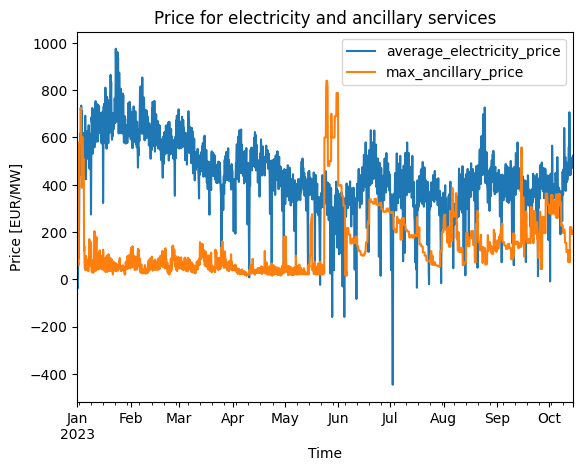

In [35]:
cut_off_el_df = electricity_df[electricity_df["time_start"] < datetime(year = 2023, month = 10, day = 15)]
cut_off_an_df = ancillary_df[ancillary_df["time_start"] < datetime(year = 2023, month = 10, day = 15)]
ax = cut_off_el_df.plot(x = "time_start", y = "average_electricity_price", title = "Price for electricity and ancillary services")
cut_off_an_df.plot(ax = ax, x = "time_start", y = "max_ancillary_price")
ax.set_xlabel("Time")
ax.set_ylabel("Price [EUR/MW]")

In [26]:
date = datetime(year = 2023, day = 5, month=7)

def decision_maker(date, volume, ancillary_df,electricity_df, mode):
    '''mode: string. opt or avg.
        datetime: start time. must be in datetime format
        volume: float
        ancillary_df, electricity_df: dataframe formatted as the corresponding dataframes above
    '''
    
    ancillary_df = ancillary_df[ancillary_df["time_start"] == date]
    electricity_df = electricity_df[electricity_df["time_start"]== date]
  

    average_electricity_price = electricity_df["average_electricity_price"].values[0]
    opt_df = pd.DataFrame({'time_start':[date]})
    opt_df["time_start"] = date
    if mode == "avg":
        ancillary_price = ancillary_df["average_ancillary_price"].values[0] 
    elif mode =="max":
        ancillary_price = ancillary_df["max_ancillary_price"].values[0]
    elif mode == "min":
        ancillary_price = ancillary_df["max_ancillary_price"].values[0]
    opt_df["optimal_income"] = max(ancillary_price,average_electricity_price)*volume
    opt_df["income_difference"] = abs(ancillary_price-average_electricity_price)*volume
    if ancillary_price > average_electricity_price:
        opt_df["optimal_ancillary_volume"] = volume
        opt_df["optimal_electricity_volume"] = 0
        return opt_df
    opt_df["optimal_ancillary_volume"] = 0
    opt_df["optimal_electricity_volume"] = volume
    return opt_df
    

In [28]:
decision_maker(date,5,ancillary_df,electricity_df,mode = "max")

,time_start,optimal_income,income_difference,optimal_ancillary_volume,optimal_electricity_volume
0,2023-07-05,1844.95,524.95,0,5


In [29]:
# Single (existing example) plant
#maximal capacity and minimal capacity
# reservoar: assume full once and must be used up until the end of the year
    #Use graph as reference
# run of river: infinite reservoar
# run for every day
# graph of capacity of electricity production/ancillary service

In [30]:
def all_dates_optimize(dates,volume,ancillary_df,electricity_df,mode):
    dates_list = dates.to_numpy()
    master_df = pd.DataFrame()
    for date in dates_list[1:]:
        master_df = pd.concat([decision_maker(date,volume,ancillary_df,electricity_df,mode = mode), master_df], ignore_index= True)
    display(master_df)
    return master_df


In [31]:
def reservoir_optimize(dates, max_volume, min_volume, reservoir, ancillary_df,electricity_df, mode):
    '''mode: string. opt or avg.
        datetime: series of times
        max_volume: float. maximal capacity of plant
        min_volume: float. minimal capacity of plant
        resevoir: size of reservoir
        ancillary_df, electricity_df: dataframe formatted as the corresponding dataframes above
    '''
    volume = max_volume-min_volume
    optimized_df = all_dates_optimize(electricity_df["time_start"],volume,ancillary_df,electricity_df,mode = "avg").sort_values(by = 'optimal_income', ascending=False)
    #So far ignoring residual capacity for simplicity. Assumes reservoir size is divisible by volume
    reservoir_df = optimized_df.head(int(np.floor(reservoir/volume)))
    #only works for constant volume and if index is ordered
    #We are ignoring the discount rate so far
    reservoir_df = reservoir_df.sort_values("time_start")
    print(reservoir_df.reset_index().index.values)
    reservoir_df["volume_left"]  = reservoir - (reservoir_df.reset_index().index+1)*volume
    #devide by 1000 to scale down
    reservoir_df["current_total_income"] = reservoir_df["optimal_income"].cumsum()/1000
    return reservoir_df
    
reservoir_df = reservoir_optimize(date,5,1,100,ancillary_df,electricity_df,mode = "max")
reservoir_df

,time_start,optimal_income,income_difference,optimal_ancillary_volume,optimal_electricity_volume
0,2023-11-02 20:00:00,1012.160000,959.438367,0,4
1,2023-11-02 16:00:00,1459.000000,1203.772331,0,4
2,2023-11-02 12:00:00,1019.480000,950.646779,0,4
3,2023-11-02 08:00:00,1043.760000,981.149344,0,4
4,2023-11-02 04:00:00,722.320000,660.625921,0,4
...,...,...,...,...,...
1830,2023-01-01 20:00:00,354.680000,319.842974,0,4
1831,2023-01-01 16:00:00,479.800000,444.642912,0,4
1832,2023-01-01 12:00:00,59.040000,25.812124,0,4
1833,2023-01-01 08:00:00,41.780604,69.940604,4,0


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]


,time_start,optimal_income,income_difference,optimal_ancillary_volume,optimal_electricity_volume,volume_left,current_total_income
1737,2023-01-17 08:00:00,3243.12,3222.731224,0,4,96,3.24312
1735,2023-01-17 16:00:00,3110.44,3086.848667,0,4,92,6.35356
1731,2023-01-18 08:00:00,3084.52,3060.195495,0,4,88,9.43808
1719,2023-01-20 08:00:00,3458.72,3432.639601,0,4,84,12.89680
1718,2023-01-20 12:00:00,3064.84,3043.750843,0,4,80,15.96164
1717,2023-01-20 16:00:00,3338.32,3315.129788,0,4,76,19.29996
1701,2023-01-23 08:00:00,3901.96,3873.467641,0,4,72,23.20192
1700,2023-01-23 12:00:00,3522.36,3498.022509,0,4,68,26.72428
1699,2023-01-23 16:00:00,3857.72,3826.232500,0,4,64,30.58200
1698,2023-01-23 20:00:00,3166.92,3144.540258,0,4,60,33.74892


<Axes: xlabel='time_start', ylabel='volume_left'>

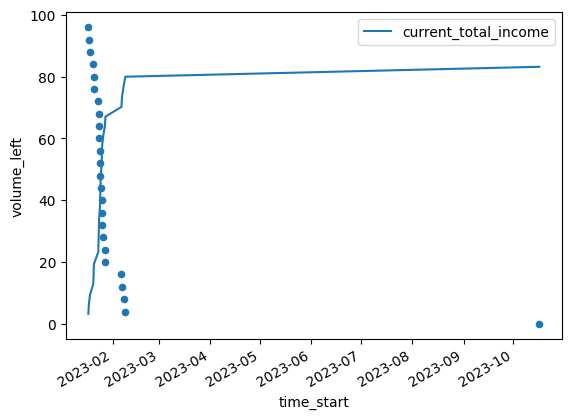

In [25]:
#plotting reservoar volume as a function of time
ax = reservoir_df.plot(x = "time_start", y = "volume_left",kind = "scatter")
reservoir_df.plot(ax=ax,x = "time_start", y = "current_total_income" )


In [ ]:
#Questions and followups
#Is there any point in iterating through all the ancillary service bids? This will be the most accurate but will also make calculations unnecessarily complicated. 
#I suggest doing a sensitivity analysis instead with using the highest and lowest bid prices

In [ ]:
electricity_df["average_electricity_price_scaled"] = electricity_df["average_electricity_price"]
ax = electricity_df.plot(x = "time_start", y = "average_electricity_price", title = "Price for electricity and ancillary services")
ancillary_df.plot(ax = ax, x = "time_start", y = "average_ancillary_price")
ax.set_xlabel("Time")
ax.set_ylabel("Price [EUR/MW]")